In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import nengo
import nengo_spa as spa
import numpy as np
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

In [3]:
from cue.analysis.analysis import bootstrap_ci
from cue.model.amlearn import AML
from cue.utils.plotting import *

In [4]:
style()

In [5]:
d = 32
vocab = spa.Vocabulary(d, strict=False, rng=np.random.RandomState(49))
n_items = 5
item_duration = 1.

def err_stimulus(t):
    if t <= n_items * item_duration:
        v = vocab.parse('Out' + str(int(t // item_duration))).v
    else:
        v = np.zeros(d)
    return np.concatenate(((1., 1.), v))

def pes_err(t, x):
    if t <= n_items * item_duration:
        return x - err_stimulus(t)[2:]
    else:
        return np.zeros(d)
    
def pre_stimulus(t):
    return vocab.parse('In' + str(int((t // item_duration) % n_items))).v

with nengo.Network(seed=1) as model:
    pre = nengo.Ensemble(50 * d, d)
    post = nengo.Node(size_in=d)
    post_pes = nengo.Node(size_in=d)
    c = nengo.Connection(pre, post, learning_rule_type=AML(d), function=lambda x: np.zeros(d))
    c_pes = nengo.Connection(pre, post_pes, learning_rule_type=nengo.PES(), function=lambda x: np.zeros(d))
    err = nengo.Node(err_stimulus)
    inp = nengo.Node(pre_stimulus)
    nengo.Connection(inp, pre)
    nengo.Connection(err, c.learning_rule)
    err_pes = nengo.Node(pes_err, size_in=d)
    nengo.Connection(post_pes, err_pes)
    nengo.Connection(err_pes, c_pes.learning_rule)
    p_pre = nengo.Probe(pre, synapse=0.01)
    p_post = nengo.Probe(post, synapse=0.01)
    p_post_pes = nengo.Probe(post_pes, synapse=0.01)
    p_err = nengo.Probe(err, synapse=0.01)

In [6]:
with nengo.Simulator(model) as sim:
    sim.run(2 * n_items * item_duration)

Building finished in 0:00:02.                                                                                           
[########################################## Simulating... 41%                                           ] ETA: 0:00:07

/home/jgosmann/Documents/projects/nengo_spa/nengo_spa/vocab.py:132: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=8)
  len(self._key2idx)))


Simulating finished in 0:00:11.                                                                                         


In [7]:
vocab_out = vocab.create_subset(['Out' + str(i) for i in range(n_items)])
vocab_in = vocab.create_subset(['In' + str(i) for i in range(n_items)])

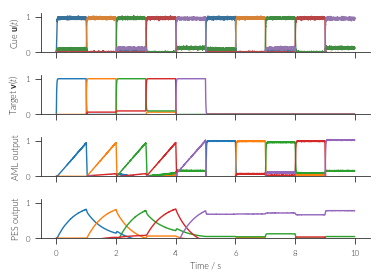

In [8]:
fig = plt.figure(figsize=(textwidth, 1.75 * row_height))

with sns.color_palette(desat=0.66):
    ax1 = fig.add_subplot(4, 1, 1)
    ax1.plot(sim.trange(), spa.similarity(sim.data[p_pre], vocab_in))
    ax1.set_ylabel(r"Cue $\mathbf{u}(t)$")

ax2 = fig.add_subplot(4, 1, 2, sharex=ax1, sharey=ax1)
ax2.plot(sim.trange(), spa.similarity(sim.data[p_err][:, 2:], vocab_out))
ax2.set_ylabel(r"Target $\mathbf{v}(t)$")

ax3 = fig.add_subplot(4, 1, 3, sharex=ax1, sharey=ax1)
ax3.plot(sim.trange(), spa.similarity(sim.data[p_post], vocab_out))
ax3.set_ylabel("AML output")

ax4 = fig.add_subplot(4, 1, 4, sharex=ax1, sharey=ax1)
ax4.plot(sim.trange(), spa.similarity(sim.data[p_post_pes], vocab_out))
ax4.set_ylabel("PES output")
ax4.set_xlabel("Time / s")

ax1.set_ylim(bottom=0.)

for ax in fig.axes:
    ax.label_outer()
sns.despine(fig)
fig.tight_layout()

In [9]:
save_tight_fig(fig, '../../../phd-thesis/figures/aml.pdf')